Voici un résumé en Markdown du notebook **kaggle_notebook_introduction.ipynb** :

---

# Résumé du notebook : Kaggle News Portal User Interactions

## 1. Découverte et exploration des données

- **Fichiers principaux :**
  - `articles_metadata.csv` : métadonnées des articles (id, catégorie, date de création, nombre de mots…)
  - `clicks_hour_000.csv` (et suivants) : logs de clics utilisateurs (user_id, session_id, article cliqué, device, pays, etc.)

- **Exploration :**
  - Analyse de la distribution du nombre de mots par article.
  - Analyse du nombre de clics par session.
  - Interprétation des principales colonnes du dataset.

---

## 2. Approches de recommandation testées

### a. **Baseline / Content-based par catégorie**
- Regroupe les articles cliqués par utilisateur.
- Calcule la fréquence de clics par catégorie pour chaque utilisateur.
- Recommande les articles des catégories préférées de l’utilisateur.
- Limite : lent si beaucoup d’interactions.

### b. **Collaborative Filtering (librairie Surprise)**
- Fusionne les clics et les métadonnées pour obtenir une matrice utilisateur/catégorie.
- Utilise la librairie [Surprise](https://github.com/NicolasHug/Surprise) et l’algorithme SVD.
- Évalue la RMSE sur un jeu de test.
- Génère le top-N des recommandations par utilisateur.

### c. **Content-based Filtering avec embeddings**
- Utilise les embeddings d’articles (`articles_embeddings.pickle`).
- Deux méthodes :
  1. Calcul du cosinus de similarité à la volée (CPU, lent).
  2. Calcul d’un kernel linéaire sur un sous-échantillon (plus rapide, mais nécessite plus de RAM).
- Recommande les articles les plus similaires à ceux déjà lus par l’utilisateur.

---

## 3. Comparaison des résultats

- Les recommandations par catégorie et par filtrage collaboratif donnent des résultats similaires.
- L’approche par embeddings permet d’aller plus loin dans la personnalisation, mais est limitée par les ressources matérielles.

---

## 4. Conclusion

- Plusieurs méthodes de recommandation sont testées et comparées : baseline par catégorie, filtrage collaboratif, filtrage par contenu avec embeddings.
- Le notebook met en avant les avantages et limites de chaque approche, notamment en termes de performance et de temps de calcul.
- Il constitue une bonne base pour explorer et comparer différentes stratégies de recommandation sur un dataset réel.

---

# Don't forget to UPVOTE if it helped you. Thank you

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install progressbar
import progressbar

import os

from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, cross_validate

from sklearn.metrics.pairwise import linear_kernel

# Discovering dataset

### Articles_metadata meaning (according to me)
* article_id : unique id for the article
* category_id : the category of the article, there is 461 category.
* created_at_ts : timestamp when the article as been created. You should remove the 3 last numbers. Oldest article : 2006/09/27 11:14:35. Newest : 2018/3/13 12:12:30.
* publisher_id : seems empty. only 0
* words_count : how many words in the article. From 0 (seems a bug) to 6690. Distribution is available in few cells.

In [3]:
articles_metadata = pd.read_csv('../input/news-portal-user-interactions-by-globocom/articles_metadata.csv')  
articles_metadata

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
...,...,...,...,...,...
364042,364042,460,1434034118000,0,144
364043,364043,460,1434148472000,0,463
364044,364044,460,1457974279000,0,177
364045,364045,460,1515964737000,0,126


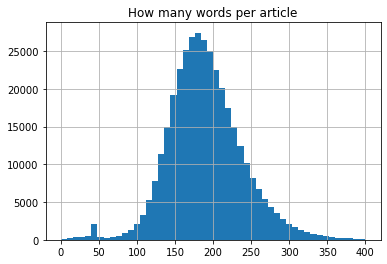

In [4]:
articles_metadata.words_count.hist(bins=50, range=(0,400))
plt.title('How many words per article');

### Clicks_hours meaning (according to me)
* user_id : unique id for the user.
* session_id : unique id for an user's session. Can appear multiple times because multiple clicks per session.
* session_start : timestamp of the session. You must remove the 3 last numbers. Oldest session : 2017/10/01 2:37:3. Newest session : 2017/10/1 3:39:19
* session_size : how many clicks per session. From 2 to 24. Distribution available few cells below.
* click_article_id : the article that has been cliked on.
* click_environment : no idea, maybe from website/app ? There is only three types, and the type 4 takes more than 90%. 
* click_deviceGroup : must be the kind of device : computer, smartphone or tablet ?
* click_os : the operation system of the device.
* click_country : which country the user come from.
* click_region : same but for region.
* click_referrer_type : good question.


In [5]:
clicks_hour_000 = pd.read_csv('../input/news-portal-user-interactions-by-globocom/clicks/clicks/clicks_hour_000.csv')  
clicks_hour_000

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1878,705,1506828968165442,1506828968000,2,119592,1506830912301,4,1,17,1,21,2
1879,705,1506828968165442,1506828968000,2,284847,1506830942301,4,1,17,1,21,2
1880,706,1506828979881443,1506828979000,3,108854,1506829027334,4,3,2,1,25,1
1881,706,1506828979881443,1506828979000,3,96663,1506829095732,4,3,2,1,25,1


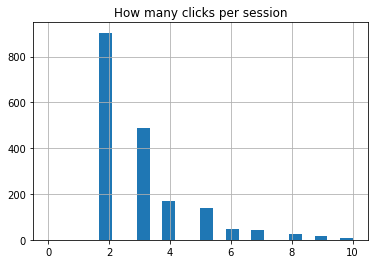

In [6]:
clicks_hour_000.session_size.hist(bins=24, range=(0,10))
plt.title('How many clicks per session');

In [7]:
clicks_hour_000.loc[clicks_hour_000.user_id == 0]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2


In [8]:
clicks_hour_000.loc[clicks_hour_000.session_id == 1506828979881443]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
1880,706,1506828979881443,1506828979000,3,108854,1506829027334,4,3,2,1,25,1
1881,706,1506828979881443,1506828979000,3,96663,1506829095732,4,3,2,1,25,1
1882,706,1506828979881443,1506828979000,3,68866,1506829125732,4,3,2,1,25,1


# Summary
We are going to try 4 differents way to predict articles to the user.

* Baseline : Just like this video (https://www.youtube.com/watch?v=YMZmLx-AUvY), we are just going to recreate a matrix for the article and the user preferenced only based on previous clicks.
* Collaborative Filtering : We are going to use the surprise librairy. https://github.com/NicolasHug/Surprise
* Content-based Filtering : We are going to use word embedding.
* Hybrid methods

# Content-based : by category
## Prepare data
Let's combine all the clicks file into a big one.

In [11]:
%%time

if not os.path.exists('clicks.csv'):
    clicks_path = []
    clicks_dir = "../input/news-portal-user-interactions-by-globocom/clicks/clicks"

    clicks_path = clicks_path + sorted(
            [
                os.path.join(clicks_dir, fname)
                for fname in os.listdir(clicks_dir)
                if fname.endswith(".csv")
            ]
        )
    print("Number of clicks csv:", len(clicks_path))

    _li = []

    for filename in clicks_path:
        df = pd.read_csv(filename, index_col=None, header=0)
        _li.append(df)

    clicks = pd.concat(_li, axis=0, ignore_index=True)
    clicks.to_csv('clicks.csv')
else:
    clicks= pd.read_csv('clicks.csv')
    
clicks

Number of clicks csv: 385
CPU times: user 27.7 s, sys: 1.09 s, total: 28.7 s
Wall time: 29.1 s


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1
2988177,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2
2988178,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2
2988179,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2


We need to group every article click per user.

In [13]:
df = clicks.groupby('user_id').agg(
    LIST_click_article_id = ('click_article_id', lambda x: list(x)),
)
df

,LIST_click_article_id
user_id,
0,"[157541, 68866, 96755, 313996, 160158, 233470,..."
1,"[235840, 96663, 59758, 160474, 285719, 156723,..."
2,"[119592, 30970, 30760, 209122]"
3,"[236065, 236294, 234686, 233769, 235665, 23513..."
4,"[48915, 44488, 195887, 195084, 63307, 336499, ..."
...,...
322892,"[42567, 39894]"
322893,"[50644, 36162]"
322894,"[36162, 168401]"


In [16]:
%%time
#Code need optimization

if not os.path.exists('../input/p9-data/df.csv'):
    pbar = progressbar.ProgressBar(widgets=[progressbar.Percentage(), progressbar.Bar()], maxval=len(df)).start()
    
    df['categories'] = ''

    for index, row in df.iterrows():
        pbar.update(index)
        _list_row = []
        for article in row.LIST_click_article_id:
            _list_row.append(articles_metadata[articles_metadata.article_id == article].category_id.values[0])
        df.loc[index]['categories']=_list_row
    df.to_csv('df.csv')
    pbar.finish()
else:
    df= pd.read_csv('../input/p9-data/df.csv')

CPU times: user 703 ms, sys: 79.9 ms, total: 783 ms
Wall time: 787 ms


In [15]:
df

,user_id,LIST_click_article_id,categories
0,0,"[157541, 68866, 96755, 313996, 160158, 233470,...","[281, 136, 209, 431, 281, 375, 186, 186]"
1,1,"[235840, 96663, 59758, 160474, 285719, 156723,...","[375, 209, 123, 281, 412, 281, 331, 412, 435, ..."
2,2,"[119592, 30970, 30760, 209122]","[247, 26, 26, 332]"
3,3,"[236065, 236294, 234686, 233769, 235665, 23513...","[375, 375, 375, 375, 375, 375, 281, 375, 375, ..."
4,4,"[48915, 44488, 195887, 195084, 63307, 336499, ...","[92, 81, 317, 317, 132, 437, 399]"
...,...,...,...
322892,322892,"[42567, 39894]","[67, 66]"
322893,322893,"[50644, 36162]","[99, 43]"
322894,322894,"[36162, 168401]","[43, 297]"
322895,322895,"[289197, 63746]","[418, 133]"


Now we have article_id and category_id that users clicked on.

## Calculate clicks per user
How many time an user clicked on a article from X category_id.

In [23]:
def inputUserRatings(userId):
    _matrix = pd.DataFrame(columns=['click'])
    _row = df.loc[userId]['categories']
    _row = _row.replace('[', '').replace(']', '').replace(',', '').split()
    
    for index, val in pd.Series(_row).value_counts().items():
        _matrix.loc[index] = int(val)
         
    _matrix['click_norm'] = _matrix.apply(lambda x : x / _matrix['click'].max())
    _matrix = _matrix.reset_index()
    _matrix = _matrix.rename(columns={"index": "category_id"})
    _matrix['category_id'] = _matrix['category_id'].astype(int)
    
    return _matrix

In [24]:
inputUserRatings(0)

,category_id,click,click_norm
0,281,2,1.0
1,186,2,1.0
2,136,1,0.5
3,209,1,0.5
4,431,1,0.5
5,375,1,0.5


## Recommend books from the 360 000 books available based on prefered category_id.

In [28]:
articles_matrix = articles_metadata.loc[:, ['article_id', 'category_id']]
display(articles_matrix.dtypes)

article_id     int64
category_id    int64
dtype: object

In [31]:
def recommend5(userId, articles_matrix):
    _input_user_ratings = inputUserRatings(userId)
    _articles_matrix = articles_matrix
    
    _weighed_articles_matrix = pd.DataFrame(columns=['article_id', 'category_id', 'weight'])
    _weighed_articles_matrix['article_id'] = _articles_matrix['article_id']
    _weighed_articles_matrix['category_id'] = _articles_matrix['category_id']
    #display(_weighed_articles_matrix.dtypes)

    _weighed_articles_matrix['weight'] = _weighed_articles_matrix['category_id'].apply(lambda x :
                                                                                        0                                                                                           
                                                                                       if(_input_user_ratings.loc[_input_user_ratings['category_id'] == x].empty == True)
                                                                                       else
                                                                                        _input_user_ratings.loc[_input_user_ratings['category_id'] == x].click_norm.values[0]
                                                                                      )

    
    return _weighed_articles_matrix[_weighed_articles_matrix.weight > 0].sort_values(by=['weight'], ascending=False)

In [32]:
%%time
res = recommend5(0 , articles_matrix)
res

CPU times: user 2min 17s, sys: 4.31 s, total: 2min 21s
Wall time: 2min 12s


,article_id,category_id,weight
158832,158832,281,1.0
154313,154313,281,1.0
154323,154323,281,1.0
154322,154322,281,1.0
154321,154321,281,1.0
...,...,...,...
95817,95817,209,0.5
95816,95816,209,0.5
95815,95815,209,0.5
95814,95814,209,0.5


As you can see, it works but it takes too much time. Approx 2 min per user. Only works if user has few interactions.
We will use the result of this algo to compare with the next algorithm.

# Collaborative filtering
Let's try with using the surprise librairy.
https://medium.com/hacktive-devs/recommender-system-made-easy-with-scikit-surprise-569cbb689824
## Prepare data

In [33]:
clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [34]:
articles_metadata.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [35]:
%%time
dataframe = clicks.merge(articles_metadata, left_on='click_article_id', right_on='article_id')

CPU times: user 2.8 s, sys: 617 ms, total: 3.42 s
Wall time: 3.41 s


In [36]:
dataframe = dataframe[['user_id', 'article_id', 'category_id']]
dataframe

,user_id,article_id,category_id
0,0,157541,281
1,20,157541,281
2,44,157541,281
3,45,157541,281
4,76,157541,281
...,...,...,...
2988176,195186,2221,1
2988177,75658,271117,399
2988178,217129,20204,9
2988179,217129,70196,136


In [40]:
%%time
series = dataframe.groupby(['user_id', 'category_id']).size()
user_rating_matrix = series.to_frame()
user_rating_matrix = user_rating_matrix.reset_index()
user_rating_matrix.rename(columns = {0:'rate'}, inplace = True)

CPU times: user 2.46 s, sys: 185 ms, total: 2.64 s
Wall time: 2.63 s


In [41]:
user_rating_matrix

,user_id,category_id,rate
0,0,136,1
1,0,186,2
2,0,209,1
3,0,281,2
4,0,375,1
...,...,...,...
1882297,322894,297,1
1882298,322895,133,1
1882299,322895,418,1
1882300,322896,26,1


This is very similar to our previous function *inputUserRatings* but here it's a dataframe with every user.

In [83]:
reader = Reader(rating_scale=(1,10))
_x = user_rating_matrix.loc[user_rating_matrix.rate > 1]
data = Dataset.load_from_df(_x[['user_id', 'category_id', 'rate']], reader)

print('We have selects', len(_x), 'interactions.')

We have selects 503616 interactions.


## Using the surprise librairy

In [84]:
%%time
trainset, testset = train_test_split(data, test_size=0.25)
print('Test set lenght :', len(testset))
print('Train set lenght :', len(_x) - len(testset))

Test set lenght : 125904
Train set lenght : 377712
CPU times: user 2.46 s, sys: 18.3 ms, total: 2.48 s
Wall time: 2.48 s


In [85]:
%%time
from surprise import SVD, accuracy
algo = SVD()
algo.fit(trainset)

CPU times: user 43.6 s, sys: 25.5 ms, total: 43.6 s
Wall time: 43.7 s


In [86]:
%%time
predictions = algo.test(testset)
print('Number of predictions in Test set :', len(predictions))

Number of predictions in Test set : 125904
CPU times: user 1.42 s, sys: 41.7 ms, total: 1.46 s
Wall time: 1.43 s


In [87]:
%%time
accuracy.rmse(predictions)

RMSE: 7.4133
CPU times: user 128 ms, sys: 972 µs, total: 129 ms
Wall time: 127 ms


7.413344626148932

In [88]:
from collections import defaultdict


def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [89]:
%%time
top_n = get_top_n(predictions, n=10)

CPU times: user 267 ms, sys: 5.96 ms, total: 273 ms
Wall time: 272 ms


In [ ]:
with open("top_n.txt", "wb") as fp:
    pickle.dump(top_n, fp)

In [93]:
def findRecom(dic, userId):
    res = []
    query = dic[userId]
    for uid, user_ratings in query:
        res.append(uid)
    return res

In [94]:
findRecom(top_n, 0)

[186, 281]

Let's compare the result with our first algo

In [96]:
res[['category_id', 'weight']].groupby('category_id').mean().sort_values('weight', ascending=False)

,weight
category_id,
186,1.0
281,1.0
136,0.5
209,0.5
375,0.5
431,0.5


We can see we have the same result as previously.

# Content-based : using articles embedding

## Method 1 : We calculate every combinaison each time (use CPU).

In [97]:
pickle = pd.read_pickle('../input/news-portal-user-interactions-by-globocom/articles_embeddings.pickle')
pickle.shape

In [98]:
from operator import itemgetter

def find_top_n_indices(data, top=5):
    indexed = enumerate(data)
    sorted_data = sorted(indexed, 
                         key=itemgetter(1), 
                         reverse=True) 
    return [d[0] for d in sorted_data[:top]] 

In [99]:
def recommendFromArticle(article_id, top):
    score = []
    for i in range(0, len(pickle)):
        if(article_id != i):
            cos_sim = np.dot(pickle[article_id], pickle[i])/(np.linalg.norm(pickle[article_id])*np.linalg.norm(pickle[i]))
            score.append(cos_sim)
    
    _best_scores = find_top_n_indices(score, top)
            
    return _best_scores

In [100]:
%%time
recommendFromArticle(157077, 10)

CPU times: user 10.5 s, sys: 28.8 ms, total: 10.5 s
Wall time: 10.5 s


[156576,
 159580,
 158063,
 159644,
 161399,
 153833,
 207423,
 158717,
 158719,
 155014]

## Method 2 : Creating a linear kernel (use Memory)
We must sample the pickle because we 'only' have 16go of RAM.

In [102]:
cosine_similarities = linear_kernel(pickle[:50000], pickle[:50000]) 
cosine_similarities.shape

(50000, 50000)

In [103]:
titles = articles_metadata['article_id']
indices = pd.Series(articles_metadata.index, index=articles_metadata['article_id'])

In [104]:
def simScores(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    
    return sim_scores
    print(sim_scores)

In [108]:
def predictWSimScores(userId):
    _input_user_ratings = inputUserRatings(userId)
    _result = []
    for index, row in _input_user_ratings.iterrows():
        _x = simScores(row.category_id)
        for i in range(1, row.click + 1):
            _result = _result + _x
    return _result

In [112]:
%%time
test = predictWSimScores(0)

CPU times: user 697 ms, sys: 4.75 ms, total: 702 ms
Wall time: 700 ms


In [113]:
pd.DataFrame(test, columns =['category_id', 'score']).groupby('category_id').mean().sort_values('score',ascending=False).head(5)

,score
category_id,
1389,78.464760
1256,77.300613
1294,77.235832
1136,76.995064
1474,76.893272
